# SBN Project: High-throughput Sequence To Function Mapping

## Introduction

The central dogma of biology is that genomic sequences determine function, ie. from DNA, to RNA, to protein function. Therefore, mutations, caused by replication errors, deletions, acquisition of new DNA, etc., will often alter protein sequences or expression, and thus protein function. While these alteration are often deleterious, they can very rarely improve cell growth compared to its ancestor (the rest of the population). This growth advantage is measured by a fitness score, ie. the average reproductive success of the cell genotype in a given environment, relative to other genotypes.

Fitness conferrings mutations are therefore very interesting, as they have many impacts, from being the cause of major health problems such as antibiotic resistance and cancer, to allowing the engineering of enzymes and organisms used in green chemistry. However, the process of natural evolution leading to these mutations is extremely slow. In a simple bacterium like *E. coli*, experimental studies have shown that the emergence of beneficial mutations can take days to months, depending on the environment stress.

## High-throughput sequence to function mapping

![doug-fig1-dms-to-analyze-prot-prev-proj_orig.jpg](doug-fig1-dms-to-analyze-prot-prev-proj_orig.jpg)

The figure above ([source](http://www.fieldslab.org/previous-projects.html)) summarizes the deep mutational scanning approach used to analyze protein function. In such experiments, DNA synthesis is leveraged to develop a library of sequences usually associated with a protein or protein-coding promoters. These sequences are then introduced to create a library of cells where each cell harbors a unique sequence. The library goes through selection, which changes the frequencies of the different mutations: variants bearing beneficial mutations increase in abundance, and vice versa. Finally, high-throughput sequencing is performed on the selected and input libraries, leading to variant counts corresponding to their respective abundance. The resulting sequencing data is used to compute the enrichment ratio of each variant.

## Objectives for the project

The objectives of this project are as follow:

- work with a simplified dataset from a similar experiment ([Choudhury A. *et al.* 2020](https://www.embopress.org/doi/abs/10.15252/msb.20199265)) and study how a measure of fitness can help to understand resistance to an antibiotic.
- replicate some of the analyses in the paper, studying in particular the effect of combinations of mutations on cell fitness.

In [1]:
# Python libraries.
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns

import plotly.io as pio
png_renderer = pio.renderers["svg"]
png_renderer.width = 600
png_renderer.height = 600

pio.renderers.default = "svg"

In [19]:
# Open a Python console linked to the current kernel.
%qtconsole

## Preprocessing

In [3]:
def identify_non_synonymous_mutations(aa_change):
    """Extract non synonymous mutations from a string of comma-separated mutations.
    
    The mutations must be formatted as AXXXB, where A is the original amino acid,
    XXX its position in the sequence and B the mutated amino acid.
    
    Keyword arguments:
    aa_change -- string of comma separated mutations.
    
    Return: a similarly formatted string containing non-synonymous mutations.
    """
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change) > 0:
        for mutation in aa_change.split(","):
            if mutation[0].upper() != mutation[-1].upper():
                mutations_list.append(mutation)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous

In [4]:
# Read processed dataset. This was obtained from the Rifampicin_B.csv dataset, where
# the counts were summed by grouping on individual genotypes. Only the amino acid change
# and the counts features are kept, the rest will be recomputed.
df = pd.read_csv("input/RifampicinB_sampleDataset.csv", 
                 index_col=0, 
                 usecols=[0, 1, 5, 6, 7, 8])

# Drop rows with unidentified mutations.
df.dropna(inplace=True)

# Extract the non-synonymous mutations from the aa_change column.
df["non_syn_mutations"] = df.aa_change.apply(identify_non_synonymous_mutations)

# Count the number of non-synonymous mutations.
df["n_non_syn"] = df.non_syn_mutations.apply(lambda x: len(x.split(',')) if x != "" else 0)

# Sort DataFrame by the pre-selection counts.
df.sort_values('pre', ascending=False, ignore_index=True, inplace=True)

# To be able to compare epistasis effects on fitness, non-synonymous mutations need to
# be grouped and their counts summed. To avoid grouping the synonymous mutations and
# the wild type, special codes are added to the non_syn_mutations columns for these rows.

# The row with the highest pre-selection count is the wild type.
df.at[0, "non_syn_mutations"] = "WT"

# All rows that don't contain the SPM are removed.
spm = df.aa_change[0]
df = df.loc[df.aa_change.str.find(spm) != -1]

# Add a code in the non_syn_mutations column to each synonymous mutation so that they don't
# get grouped together later.
n_syn_mutations = len(df.loc[df.non_syn_mutations == '', "non_syn_mutations"])
df.loc[df.non_syn_mutations == '', "non_syn_mutations"] = \
    ["SYN"+str(i) for i in range(n_syn_mutations)]

# Group by non-synonymous mutations, sum counts and sort by pre counts.
df = (df.groupby(["non_syn_mutations", "n_non_syn"], as_index=False)
      .sum()
      .sort_values('pre', ascending=False, ignore_index=True))

# Compute the fitness score and its standard error (Rubin et al., 2017).
for cond in ["ten", "fifty", "hundred"]:
    df[cond+"_fitness"] = (np.log((df[cond]+0.5) / (df.loc[0, cond]+0.5)) -
                           np.log((df["pre"]+0.5) / (df.loc[0, "pre"]+0.5)))

    df[cond+"_error"] = np.sqrt(1/(df[cond]+0.5) + 1/(df["pre"]+0.5) +
                                1/(df.loc[0, cond]) + 1/(df.loc[0, "pre"]))

# Some reads may be erroneous. Since the targeted gene is essential, the occurence
# of stop codons should be impossible. Therefore, the stop codons are used as a control
# to determine values of bad reads and their counts threshold. A 99% confidence interval
# is used with a Poisson approximation. All counts are filtered using the pre-selection
# filter, since this will the strictest (pre-selection genotypes always have more counts).
df_stop = df.loc[df.non_syn_mutations.str.find('*') >= 0]

pre_filter = df_stop.pre.max() + 2.56*np.sqrt(df_stop.pre.max())

# Filter out reads that have counts below the threshold.
df = df.loc[(df.pre >= pre_filter) |
            (df.ten >= pre_filter) |
            (df.fifty >= pre_filter) |
            (df.hundred >= pre_filter)]
df.reset_index(drop=True, inplace=True)
display(df)

,non_syn_mutations,n_non_syn,pre,ten,fifty,hundred,ten_fitness,ten_error,fifty_fitness,fifty_error,hundred_fitness,hundred_error
0,WT,0,273933.0,50729.0,43607.0,25255.0,0.000000,0.006836,0.000000,0.007291,0.000000,0.009300
1,H526L,1,16765.0,70802.0,155590.0,107486.0,3.126949,0.009856,4.065561,0.009626,4.241883,0.010592
2,I572F,1,4345.0,53958.0,67412.0,125748.0,4.205452,0.016493,4.579346,0.016478,5.748984,0.016773
3,I572Y,1,3644.0,6998.0,12316.0,15018.0,2.338854,0.020991,3.055377,0.019549,3.799905,0.019601
4,"L533I,S574Y",2,3380.0,4694.0,45.0,16.0,2.014746,0.023069,-2.470410,0.149333,-2.938577,0.246871
...,...,...,...,...,...,...,...,...,...,...,...,...
478,"H526L,E588V,V594L",3,0.0,59.0,253.0,279.0,6.465501,1.420151,8.066167,1.415617,8.709991,1.415493
479,"H526L,A543V,I572F",3,0.0,71.0,263.0,388.0,6.649222,1.419158,8.104857,1.415564,9.039282,1.415139
480,"H526N,S574F",2,0.0,232.0,9.0,1.0,7.828415,1.415742,4.782095,1.450962,3.482454,1.633006
481,"H526N,S574Y",2,0.0,229.0,6.0,3.0,7.815428,1.415762,4.402606,1.467608,4.329752,1.511872


## Distribution of fitness in synonymous vs. all mutations

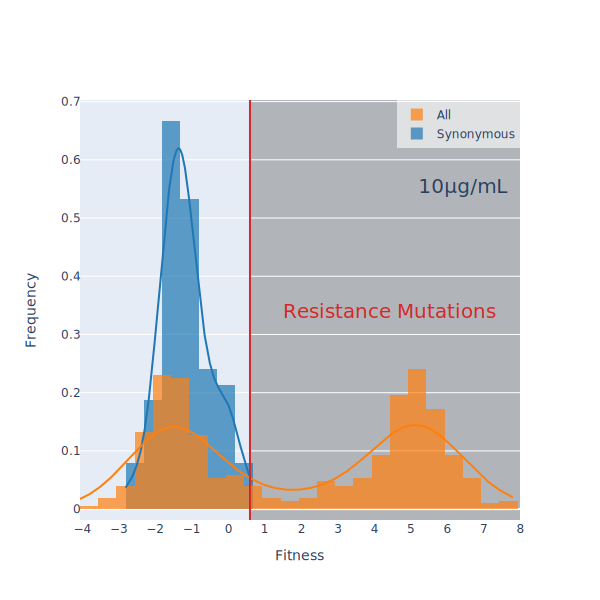

In [18]:
mu_ten, sigma_ten = stats.norm.fit(df.loc[df.n_non_syn == 0, "ten_fitness"])
hist_ten = [df.loc[df.n_non_syn == 0].ten_fitness, df.loc[df.n_non_syn != 0].ten_fitness]

group_labels = ["Synonymous", "All"]

fig = ff.create_distplot(hist_ten, group_labels, show_rug=False, bin_size=0.5)

fig.add_shape(
    type="line",
    yref="paper",
    x0=mu_ten + 2.56*sigma_ten,
    y0=0,
    x1=mu_ten + 2.56*sigma_ten,
    y1=1,
    line=dict(
        color="#d62728",
        width=2,
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_ten+2.56*sigma_ten,
    x1=8,
    y0=0,
    y1=1,
    fillcolor="#7f7f7f",
    opacity=0.5,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[
        dict(
            x=0.95,
            y=0.5,
            showarrow=False,
            text="Resistance Mutations",
            xref="paper",
            yref="paper",
            font=dict(size=20,color="#d62728")
        ),
        dict(
            xref="paper",
            yref="paper",
            x=0.98,
            y=0.83,
            showarrow=False,
            text="10µg/mL",
            font=dict(size=20)
        )
    ],
    xaxis_title="Fitness",
    yaxis_title="Frequency",
    xaxis = dict(
        dtick=1
    ),
    legend=dict(
        x=0.720,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)
fig.show()
fig.write_image("output/hist10.pdf")

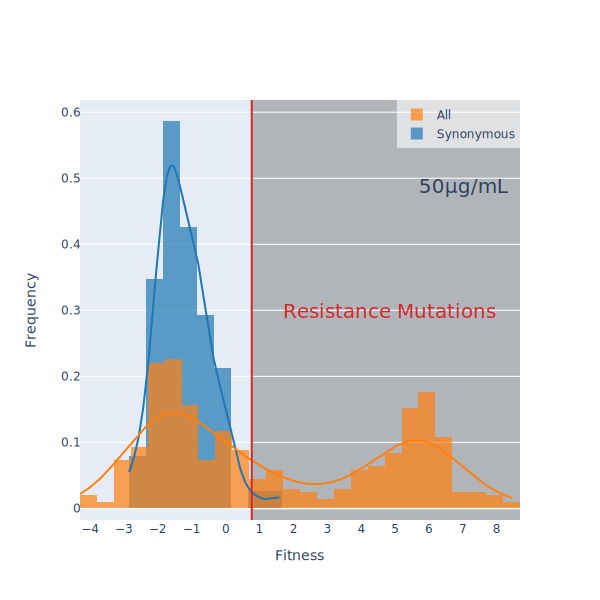

In [17]:
mu_fifty, sigma_fifty = stats.norm.fit(df.loc[df.n_non_syn == 0, "fifty_fitness"])
hist_fifty = [df.loc[df.n_non_syn == 0].fifty_fitness, df.loc[df.n_non_syn != 0].fifty_fitness]

group_labels = ["Synonymous", "All"]

fig = ff.create_distplot(hist_fifty, group_labels, show_rug=False, bin_size=0.5)

fig.add_shape(
    type="line",
    yref="paper",
    x0=mu_fifty + 2.56*sigma_fifty,
    y0=0,
    x1=mu_fifty + 2.56*sigma_fifty,
    y1=1,
    line=dict(
        color="#d62728",
        width=2,
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_fifty+2.56*sigma_fifty,
    x1=8.7,
    y0=0,
    y1=1,
    fillcolor="#7f7f7f",
    opacity=0.5,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[
        dict(
            x=0.95,
            y=0.5,
            showarrow=False,
            text="Resistance Mutations",
            xref="paper",
            yref="paper",
            font=dict(size=20,color="#d62728")
        ),
        dict(
            xref="paper",
            yref="paper",
            x=0.98,
            y=0.83,
            showarrow=False,
            text="50µg/mL",
            font=dict(size=20)
        )
    ],
    xaxis_title="Fitness",
    yaxis_title="Frequency",
    xaxis = dict(
        dtick=1
    ),
    legend=dict(
        x=0.720,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)
fig.show()
fig.write_image("output/hist50.pdf")

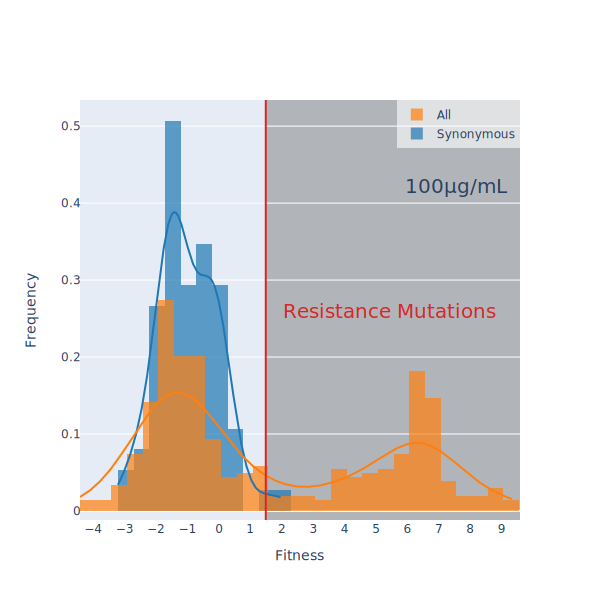

In [16]:
mu_hundred, sigma_hundred = stats.norm.fit(df.loc[df.n_non_syn == 0, "hundred_fitness"])
hist_hundred = [df.loc[df.n_non_syn == 0].hundred_fitness, df.loc[df.n_non_syn != 0].hundred_fitness]

group_labels = ["Synonymous", "All"]

fig = ff.create_distplot(hist_hundred, group_labels, show_rug=False, bin_size=0.5)

fig.add_shape(
    type="line",
    yref="paper",
    x0=mu_hundred+2.56*sigma_hundred,
    y0=0,
    x1=mu_hundred+2.56*sigma_hundred,
    y1=1,
    line=dict(
        color="#d62728",
        width=2,
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_hundred+2.56*sigma_hundred,
    x1=9.6,
    y0=0,
    y1=1,
    fillcolor="#7f7f7f",
    opacity=0.5,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[
        dict(
            x=0.95,
            y=0.5,
            showarrow=False,
            text="Resistance Mutations",
            xref="paper",
            yref="paper",
            font=dict(size=20,color="#d62728")
        ),
        dict(
            xref="paper",
            yref="paper",
            x=0.98,
            y=0.83,
            showarrow=False,
            text="100µg/mL",
            font=dict(size=20)
        )
    ],
    xaxis_title="Fitness",
    yaxis_title="Frequency",
    xaxis = dict(
        dtick=1
    ),
    legend=dict(
        x=0.720,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)
fig.show()
fig.write_image("output/hist100.pdf")

In [8]:
# Extract single mutations and their positions.
df_unique_single = df.loc[df.n_non_syn == 1]

# Extract double mutations and their positions.
df_unique_double = df.loc[df.n_non_syn == 2]
df_unique_double["mutation1"] = df_unique_double.non_syn_mutations.str.split(",",expand=True)[0]
df_unique_double["mutation2"] = df_unique_double.non_syn_mutations.str.split(",",expand=True)[1]

# Drop features that won't be used in later analyses.
df_unique_double.drop("n_non_syn", axis=1, inplace=True)
df_unique_single.drop("n_non_syn", axis=1, inplace=True)

# Merge df_unique_double and df_unique_single on each mutation. The resulting DataFrame
# will contain the features of the double mutations, along with those from each single
# mutation.
df_epistasis = pd.merge(
    df_unique_double, 
    (df_unique_single
         .rename(columns={"non_syn_mutations": "mutation"})
         .add_suffix("1")
    ), 
    how="left", 
    on="mutation1"
)
df_epistasis = pd.merge(
    df_epistasis, 
    (df_unique_single
         .rename(columns={"non_syn_mutations": "mutation"})
         .add_suffix("2")
    ), 
    how="left", 
    on="mutation2"
)

# Group by non-synonymous mutations and sum all 

# Drop NaN: these are rows where at least one single mutation couldn't be found.
df_epistasis.dropna(inplace=True)

# Compute the fitness sum, its standard error and the difference in fitness due
# to epistasis for each condition.
for cond in ["ten", "fifty", "hundred"]:
    df_epistasis[cond+"_fitness_sum"] = (df_epistasis[cond+"_fitness1"] + 
                                             df_epistasis[cond+"_fitness2"])
    df_epistasis[cond+"_fitness_sum_error"] = np.sqrt(
        np.square(df_epistasis[cond+"_error1"]) + 
        np.square(df_epistasis[cond+"_error2"])
    )
    df_epistasis[cond+"_epistasis"] = (df_epistasis[cond+"_fitness"] -
                                       df_epistasis[cond+"_fitness1"] -
                                       df_epistasis[cond+"_fitness2"])

## Scatter plot of double mutants fitness vs. sum of fitness of single mutants

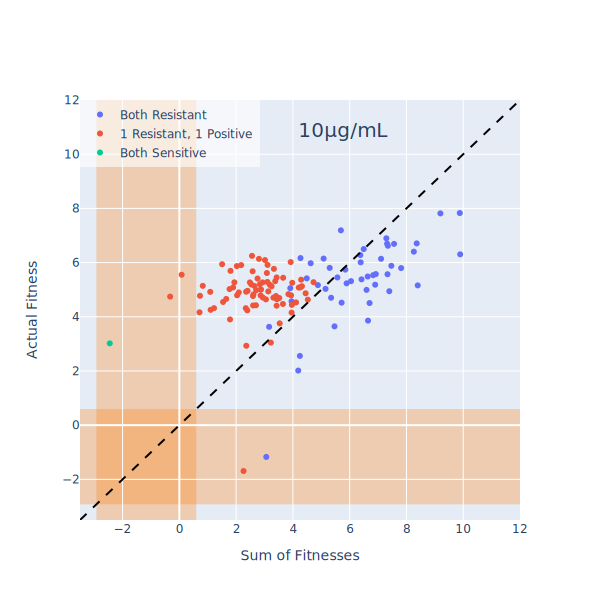

In [9]:
# Extract rows with both mutations resistant to 10ug/mL rifampicin, only one, 
# or none.
df_res_10 = df_epistasis.loc[
    (df_epistasis.ten_fitness1 > mu_ten+2.56*sigma_ten) & 
    (df_epistasis.ten_fitness2 > mu_ten+2.56*sigma_ten)
]
df_sens_10 = df_epistasis.loc[
    (df_epistasis.ten_fitness1 < mu_ten+2.56*sigma_ten) &
    (df_epistasis.ten_fitness2 < mu_ten+2.56*sigma_ten)
]
df_mixed_10 = df_epistasis.loc[
    ((df_epistasis.ten_fitness1 > mu_ten+2.56*sigma_ten) &
     (df_epistasis.ten_fitness2 < mu_ten+2.56*sigma_ten)) |
    ((df_epistasis.ten_fitness1 < mu_ten+2.56*sigma_ten) &
     (df_epistasis.ten_fitness2 > mu_ten+2.56*sigma_ten))
]

# Scatter plot of double mutants fitness vs. sum of fitness of single mutants.
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_res_10.ten_fitness_sum,
    y=df_res_10.ten_fitness,
    mode="markers",
    name="Both Resistant"
))
fig.add_trace(go.Scatter(
    x=df_mixed_10.ten_fitness_sum,
    y=df_mixed_10.ten_fitness,
    mode="markers",
    name="1 Resistant, 1 Positive"
))
fig.add_trace(go.Scatter(
    x=df_sens_10.ten_fitness_sum,
    y=df_sens_10.ten_fitness,
    mode="markers",
    name="Both Sensitive"
))

fig.add_shape(
    type="line",
    x0=-3.5,
    y0=-3.5,
    x1=12,
    y1=12,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_ten-2.56*sigma_ten,
    x1=mu_ten+2.56*sigma_ten,
    y0=0,
    y1=1,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="y",
    y0=mu_ten-2.56*sigma_ten,
    y1=mu_ten+2.56*sigma_ten,
    x0=-3.5,
    x1=12,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[dict(
            xref="paper",
            yref="paper",
            x=0.6,
            y=0.965,
            showarrow=False,
            text="10µg/mL",
            font=dict(size=20)
    )],
    xaxis_title="Sum of Fitnesses",
    yaxis_title="Actual Fitness",
    yaxis = dict(
        range=[-3.5, 12],
    ),
    xaxis = dict(
        range=[-3.5, 12],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter10.pdf")

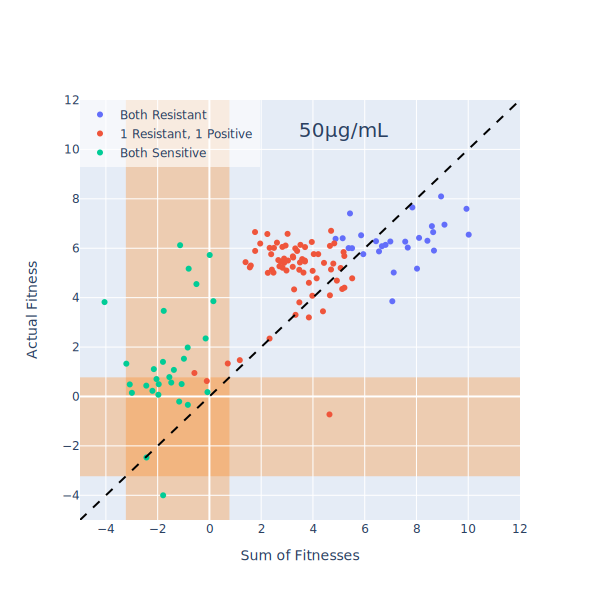

In [10]:
# Extract rows with both mutations resistant to 50ug/mL rifampicin, only one, 
# or none.
df_res_50 = df_epistasis.loc[
    (df_epistasis.fifty_fitness1 > mu_fifty+2.56*sigma_fifty) & 
    (df_epistasis.fifty_fitness2 > mu_fifty+2.56*sigma_fifty)
]
df_sens_50 = df_epistasis.loc[
    (df_epistasis.fifty_fitness1 < mu_fifty+2.56*sigma_fifty) &
    (df_epistasis.fifty_fitness2 < mu_fifty+2.56*sigma_fifty)
]
df_mixed_50 = df_epistasis.loc[
    ((df_epistasis.fifty_fitness1 > mu_fifty+2.56*sigma_fifty) &
     (df_epistasis.fifty_fitness2 < mu_fifty+2.56*sigma_fifty)) |
    ((df_epistasis.fifty_fitness1 < mu_fifty+2.56*sigma_fifty) &
     (df_epistasis.fifty_fitness2 > mu_fifty+2.56*sigma_fifty))
]

# Scatter plot of double mutants fitness vs. sum of fitness of single mutants.
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_res_50.fifty_fitness_sum,
    y=df_res_50.fifty_fitness,
    mode="markers",
    name="Both Resistant"
))
fig.add_trace(go.Scatter(
    x=df_mixed_50.fifty_fitness_sum,
    y=df_mixed_50.fifty_fitness,
    mode="markers",
    name="1 Resistant, 1 Positive"
))
fig.add_trace(go.Scatter(
    x=df_sens_50.fifty_fitness_sum,
    y=df_sens_50.fifty_fitness,
    mode="markers",
    name="Both Sensitive"
))

fig.add_shape(
    type="line",
    x0=-5,
    y0=-5,
    x1=12,
    y1=12,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_fifty-2.56*sigma_fifty,
    x1=mu_fifty+2.56*sigma_fifty,
    y0=0,
    y1=1,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="y",
    y0=mu_fifty-2.56*sigma_fifty,
    y1=mu_fifty+2.56*sigma_fifty,
    x0=-5,
    x1=12,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[dict(
            xref="paper",
            yref="paper",
            x=0.6,
            y=0.965,
            showarrow=False,
            text="50µg/mL",
            font=dict(size=20)
    )],
    xaxis_title="Sum of Fitnesses",
    yaxis_title="Actual Fitness",
    yaxis = dict(
        range=[-5, 12],
    ),
    xaxis = dict(
        range=[-5, 12],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter50.pdf")

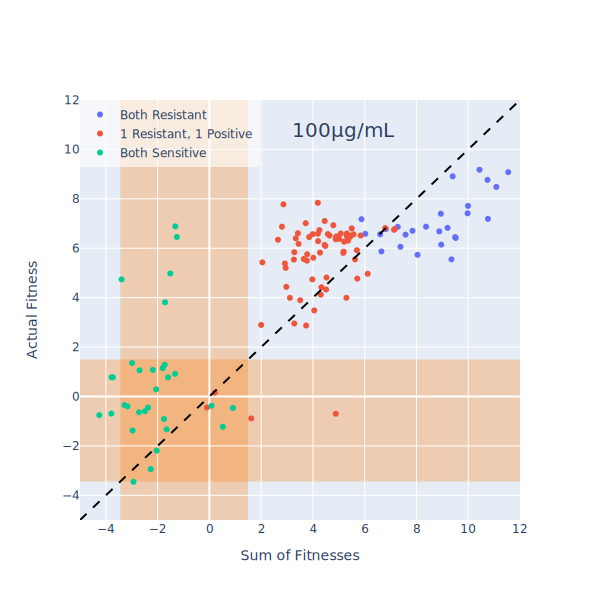

In [11]:
# Extract rows with both mutations resistant to 50ug/mL rifampicin, only one, 
# or none.
df_res_100 = df_epistasis.loc[
    (df_epistasis.hundred_fitness1 > mu_hundred+2.56*sigma_hundred) & 
    (df_epistasis.hundred_fitness2 > mu_hundred+2.56*sigma_hundred)
]
df_sens_100 = df_epistasis.loc[
    (df_epistasis.hundred_fitness1 < mu_hundred+2.56*sigma_hundred) &
    (df_epistasis.hundred_fitness2 < mu_hundred+2.56*sigma_hundred)
]
df_mixed_100 = df_epistasis.loc[
    ((df_epistasis.hundred_fitness1 > mu_hundred+2.56*sigma_hundred) &
     (df_epistasis.hundred_fitness2 < mu_hundred+2.56*sigma_hundred)) |
    ((df_epistasis.hundred_fitness1 < mu_hundred+2.56*sigma_hundred) &
     (df_epistasis.hundred_fitness2 > mu_hundred+2.56*sigma_hundred))
]

# Scatter plot of double mutants fitness vs. sum of fitness of single mutants.
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_res_100.hundred_fitness_sum,
    y=df_res_100.hundred_fitness,
    mode="markers",
    name="Both Resistant"
))
fig.add_trace(go.Scatter(
    x=df_mixed_100.hundred_fitness_sum,
    y=df_mixed_100.hundred_fitness,
    mode="markers",
    name="1 Resistant, 1 Positive"
))
fig.add_trace(go.Scatter(
    x=df_sens_100.hundred_fitness_sum,
    y=df_sens_100.hundred_fitness,
    mode="markers",
    name="Both Sensitive"
))

fig.add_shape(
    type="line",
    x0=-5,
    y0=-5,
    x1=12,
    y1=12,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="paper",
    x0=mu_hundred-2.56*sigma_hundred,
    x1=mu_hundred+2.56*sigma_hundred,
    y0=0,
    y1=1,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    xref="x",
    yref="y",
    y0=mu_hundred-2.56*sigma_hundred,
    y1=mu_hundred+2.56*sigma_hundred,
    x0=-5,
    x1=12,
    fillcolor="#ff7f0e",
    opacity=0.3,
    layer="below",
    line_width=0,
)

fig.update_layout(
    annotations=[dict(
            xref="paper",
            yref="paper",
            x=0.6,
            y=0.965,
            showarrow=False,
            text="100µg/mL",
            font=dict(size=20)
    )],
    xaxis_title="Sum of Fitnesses",
    yaxis_title="Actual Fitness",
    yaxis = dict(
        range=[-5, 12],
    ),
    xaxis = dict(
        range=[-5, 12],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter100.pdf")

## Distribution of epistasis magnitude 

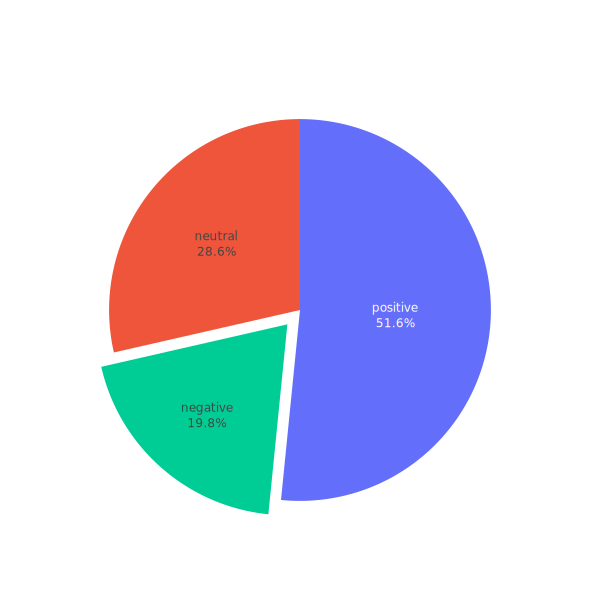

In [12]:
df_epistasis["sign_p_value"] = stats.norm.sf(abs(
    (df_epistasis.hundred_fitness_sum - df_epistasis.hundred_fitness) /
    np.sqrt(np.square(df_epistasis.hundred_fitness_sum_error) +
            np.square(df_epistasis.hundred_error))
))
mask = ((df_epistasis.hundred_fitness > df_epistasis.hundred_fitness_sum) & 
        (df_epistasis.sign_p_value <= 0.01))
df_epistasis.loc[mask, "sign"] = "positive"

mask = ((df_epistasis.hundred_fitness < df_epistasis.hundred_fitness_sum) & 
        (df_epistasis.sign_p_value <= 0.01))
df_epistasis.loc[mask, "sign"] = "negative"

mask = df_epistasis.sign_p_value > 0.01
df_epistasis.loc[mask, "sign"] = "neutral"

labels = ["positive", "neutral", "negative"]
values = [df_epistasis.sign.value_counts(normalize=True).values[0]*100,
          df_epistasis.sign.value_counts(normalize=True).values[1]*100,
          df_epistasis.sign.value_counts(normalize=True).values[2]*100]

fig = go.Figure(go.Pie(
    labels=labels, 
    values=values, 
    pull=[0, 0, 0.1], 
    textinfo='label+percent', 
    showlegend=False
))

fig.update_layout(height=600, width=600)
fig.show()

## Comparison of epistasis effects between conditions

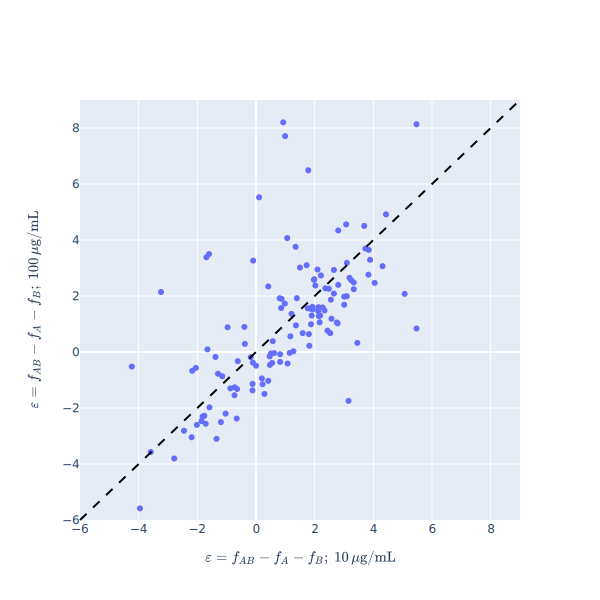

In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_epistasis.ten_epistasis,
    y=df_epistasis.hundred_epistasis,
    mode="markers"
))

fig.add_shape(
    type="line",
    xref="paper",
    yref="paper",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)

fig.update_layout(
    xaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 10\,\mu \mathrm{g/mL}$",
    yaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 100\,\mu \mathrm{g/mL}$",
    yaxis = dict(
        range=[-6, 9],
    ),
    xaxis = dict(
        range=[-6, 9],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter100vs10.pdf")

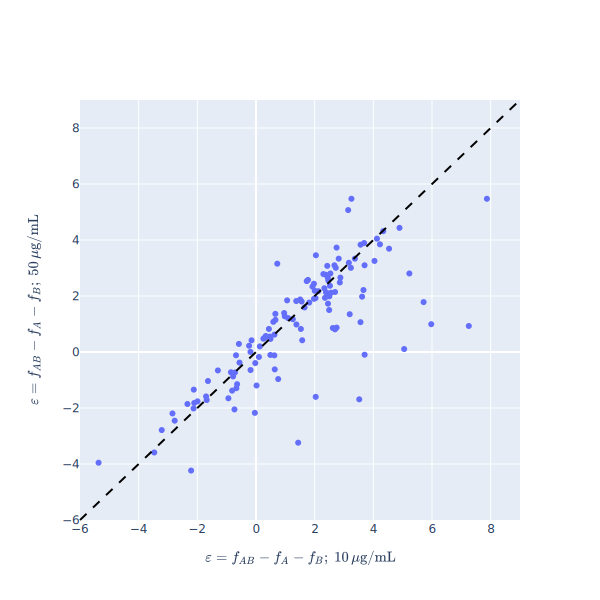

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_epistasis.fifty_epistasis,
    y=df_epistasis.ten_epistasis,
    mode="markers"
))

fig.add_shape(
    type="line",
    xref="paper",
    yref="paper",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)

fig.update_layout(
    xaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 10\,\mu \mathrm{g/mL}$",
    yaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 50\,\mu \mathrm{g/mL}$",
    yaxis = dict(
        range=[-6, 9],
    ),
    xaxis = dict(
        range=[-6, 9],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter50vs10.pdf")

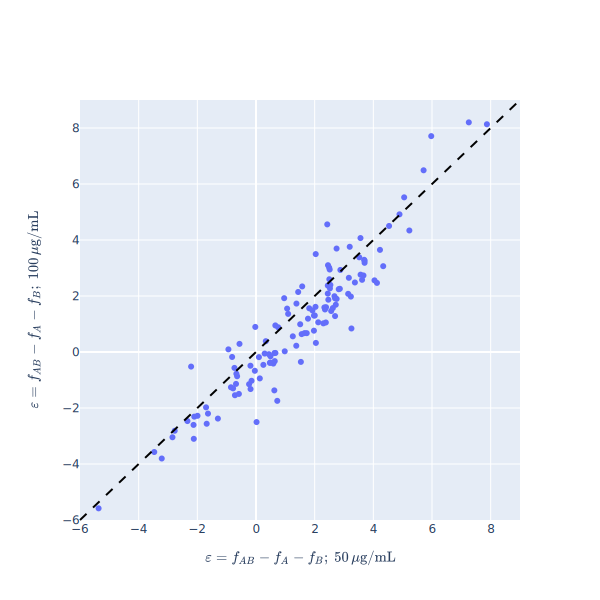

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_epistasis.fifty_epistasis,
    y=df_epistasis.hundred_epistasis,
    mode="markers"
))

fig.add_shape(
    type="line",
    xref="paper",
    yref="paper",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(
        color="black",
        width=2,
        dash="dash",
    )
)

fig.update_layout(
    xaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 50\,\mu \mathrm{g/mL}$",
    yaxis_title=r"$\varepsilon = f_{AB} - f_A - f_B;\ 100\,\mu \mathrm{g/mL}$",
    yaxis = dict(
        range=[-6, 9],
    ),
    xaxis = dict(
        range=[-6, 9],
        dtick=2,
    ),
    legend=dict(
        x=0,
        y=1,
        bgcolor="rgba(255,255,255,0.6)",
    ),
    height=600,
    width=600
)

fig.show()
fig.write_image("output/scatter100vs50.pdf")